In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml, re
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
sys.path.append('../analysis/')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, DSetLoader
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

from categoriesDef import categories

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
dataDir = '/storage/af/group/rdst_analysis/BPhysics/data/cmsRD'

In [3]:
def getLRasym(h):
    n = h.GetNbinsX()
    if n%2 != 0: raise
    out = []
    for i in range(1, n/2 + 1):
        j = n - i + 1
        x = h.GetBinCenter(j)
        dx = h.GetBinWidth(j)*0.5
        r = h.GetBinContent(j)
        dr = h.GetBinError(j)
        l = h.GetBinContent(i)
        dl = h.GetBinError(i)        
        a = (r - l) / (r + l)
        da = np.hypot(dr*2*l/((r+l)**2), dl*2*r/((r+l)**2))
        out.append([x, dx, a, da])
    return np.array(out)

# MC

## Skimmed

In [4]:
ds = DSetLoader('Bd_MuNuDst', candDir='ntuples_B2DstMu_wOC')

In [5]:
asymSkimMC = {}
for c in ['low', 'mid', 'high']:
    df = pd.DataFrame(rtnp.root2array(ds.skimmed_dir+'/'+c.capitalize()+'_bare.root', branches=['mu_eta']))
    h = create_TH1D(df['mu_eta'], binning=[50, -1.5, 1.5], name='hMCSk'+c)
    asymSkimMC[c] = getLRasym(h)

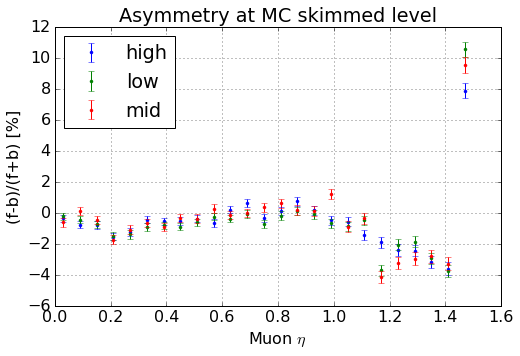

In [6]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(8,5))
for c, arr in asymSkimMC.iteritems():
    plt.errorbar(arr[:,0], 100*arr[:,2], yerr=100*arr[:,3], label=c, fmt='.')
plt.legend(loc='best', numpoints=1)
plt.xlabel(r'Muon $\eta$')
plt.ylabel('(f-b)/(f+b) [%]')
plt.title('Asymmetry at MC skimmed level')
plt.grid()

## trigger

In [7]:
tc = rt.TChain('outA/Tevts')
for fn in glob(ds.ntuples_dir.replace(ds.candDir, 'ntuples_triggerMu') + '/out_CAND_*.root'):
    tc.Add(fn)

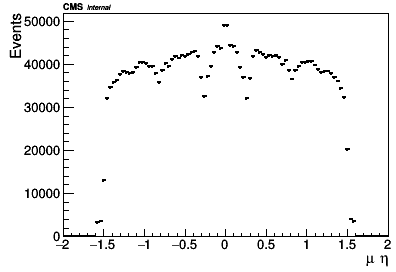

In [8]:
h = create_TH1D(np.array([]), name='hMC_trigger_mu_eta', binning=[100, -2, 2], 
                axis_title=['#mu #eta', 'Events'],)
tc.Project(h.GetName(), 'trgMu_eta')
c = drawOnCMSCanvas(CMS_lumi, [h], ['E'], size=[400,300])

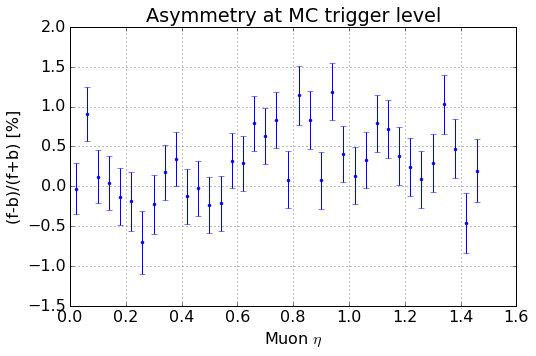

In [9]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(8,5))
arr = getLRasym(h)
sel = arr[:,0] < 1.5
plt.errorbar(arr[sel,0], 100*arr[sel,2], yerr=100*arr[sel,3], fmt='.')
plt.xlabel(r'Muon $\eta$')
plt.ylabel('(f-b)/(f+b) [%]')
plt.title('Asymmetry at MC trigger level')
plt.grid()

asymTriggerMC = arr

# Skimmed level

In [10]:
locRD = dataDir+'/skimmed/B2DstMu_210917_'
datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_210917_CAND.root')
DFs = {}
lumi_tot = {}
for c in ['low', 'mid', 'high']:
    DFs[c] = pd.DataFrame(rtnp.root2array(locRD + c.capitalize() + '_corr.root'))
# df[c+'Side'] = pd.DataFrame(rtnp.root2array(locRD + '_trkCtrl_corr.root'))
    lumi_tot[c] = getLumiByTrigger(datasets_loc, categories[c].trg, verbose=False)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


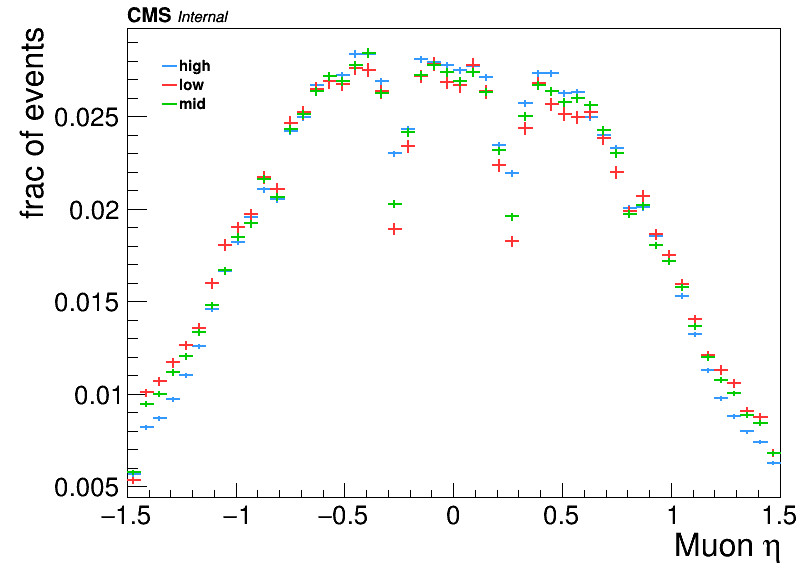

In [11]:
hSkim = {}
leg = rt.TLegend(0.2, 0.8, 0.3, 0.9)
leg.SetBorderSize(0)
leg.SetFillColor(0)
for i, (c, df) in enumerate(DFs.iteritems()):
    h = create_TH1D(df['mu_eta'], binning=[50, -1.5, 1.5], 
                    name='hSk'+c, axis_title=['Muon #eta', 'frac of events'],
                    scale_histo='norm', color=i)
    leg.AddEntry(h, c, 'l')
    hSkim[c] = h

c = drawOnCMSCanvas(CMS_lumi, hSkim.values(), 'same')
leg.Draw()

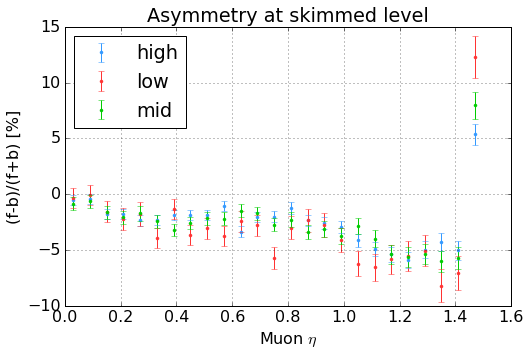

In [12]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(8,5))
asymSkim = {}
for c, h in hSkim.iteritems():
    asymSkim[c] = getLRasym(h)
    color = rt.gROOT.GetColor(h.GetLineColor()).AsHexString()
    plt.errorbar(asymSkim[c][:,0], 100*asymSkim[c][:,2], yerr=100*asymSkim[c][:,3], 
                 color=color, label=c, fmt='.')
plt.legend(loc='best', numpoints=1)
plt.xlabel(r'Muon $\eta$')
plt.ylabel('(f-b)/(f+b) [%]')
plt.title('Asymmetry at skimmed level')
plt.grid()

In [13]:
del DFs

# CAND level

In [14]:
datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_210917_CAND.root')
TFs = {}
TTs = {}
lumi_tot = {}
for floc in datasets_loc:
    n = re.search('BPH[1-5]', floc).group(0)[-1]
    TFs[n] = rt.TFile(floc, 'READ')
    TTs[n] = TFs[n].Get('outA/Tevts')
#     DFs[c] = pd.DataFrame(rtnp.root2array(locRD + c.capitalize() + '_corr.root'))
#     lumi_tot[c] = getLumiByTrigger(datasets_loc, categories[c].trg, verbose=False)

Mean: -1.46e-07 +/- 2.26e-07


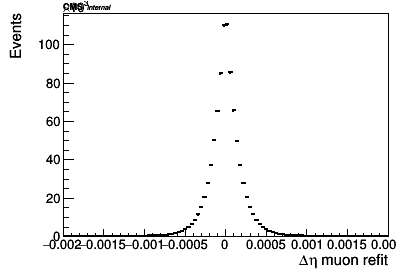

In [15]:
h = create_TH1D(np.array([]), name='refitAsymMu', binning=[100, -0.002, 0.002], 
                axis_title=['#Delta#eta muon refit', 'Events'],)
TTs['1'].Project(h.GetName(), 'mu_eta - mu_refitD0pismu_eta')
c = drawOnCMSCanvas(CMS_lumi, [h], ['E'], size=[400,300])
print 'Mean: {:1.2e} +/- {:1.2e}'.format(h.GetMean(), h.GetMeanError())

In [16]:
asymCand = {}
for i, (n, t) in enumerate(TTs.iteritems()):
    h = create_TH1D(np.array([]), binning=[50, -1.5, 1.5],
                    name='hCand'+str(n), axis_title=['Muon #eta', 'frac of events'])
    t.Project(h.GetName(), 'mu_eta')
    h.Sumw2()
    asymCand[n] = getLRasym(h)

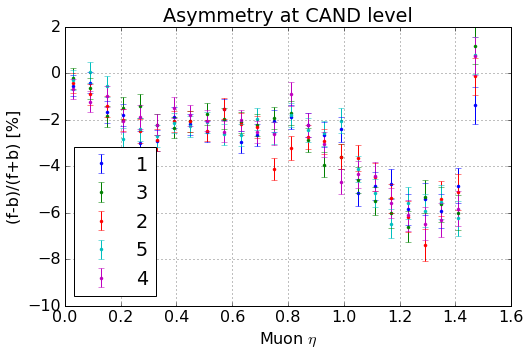

In [17]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(8,5))
for n, arr in asymCand.iteritems():
    plt.errorbar(arr[:,0], 100*arr[:,2], yerr=100*arr[:,3], 
                 label=n, fmt='.')
plt.legend(loc='best', numpoints=1)
plt.xlabel(r'Muon $\eta$')
plt.ylabel('(f-b)/(f+b) [%]')
plt.title('Asymmetry at CAND level')
plt.grid()

# Trigger level

In [18]:
tc = rt.TChain('outA/Tevts')
for fn in glob(dataDir + '/ParkingBPH*/*triggerMu_211014_CAND.root'):
    tc.Add(fn)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


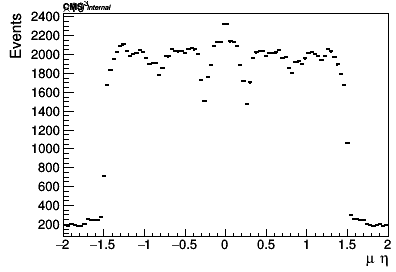

In [19]:
h = create_TH1D(np.array([]), name='h_trigger_mu_eta', binning=[100, -2, 2], 
                axis_title=['#mu #eta', 'Events'],)
tc.Project(h.GetName(), 'trgMu_eta')
c = drawOnCMSCanvas(CMS_lumi, [h], ['E'], size=[400,300])

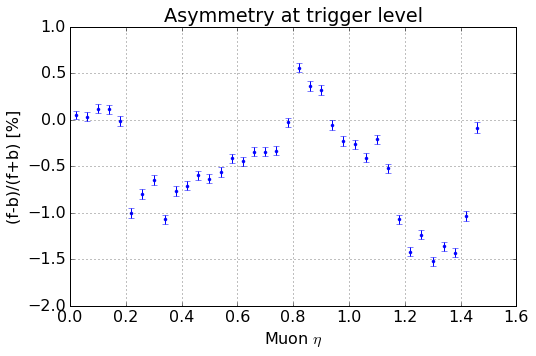

In [20]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(8,5))
arr = getLRasym(h)
sel = arr[:,0] < 1.5
plt.errorbar(arr[sel,0], 100*arr[sel,2], yerr=100*arr[sel,3], fmt='.')
plt.xlabel(r'Muon $\eta$')
plt.ylabel('(f-b)/(f+b) [%]')
plt.title('Asymmetry at trigger level')
plt.grid()

asymTrigger = arr